# Project description

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. You are asked to conduct that evaluation, so as you set to work, keep the following in mind:

The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol.

Computer vision methods can be used to determine age of a person from a photo.

The task then is to build and evaluate a model for verifying people's age.

To start working on the task, you'll have a set of photographs of people with their ages indicated.

## Initialization

In [1]:
import os
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.optimizers import Adam
import numpy as np

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
display(data.head(10))

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


## EDA

Text(0, 0.5, 'Frequency')

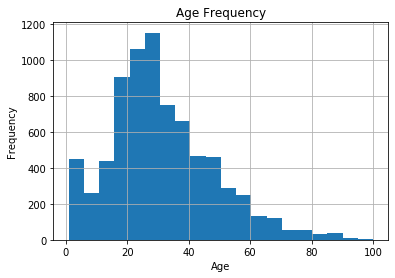

In [4]:
data['real_age'].hist(bins=20)

plt.title('Age Frequency')
plt.xlabel('Age')
plt.ylabel('Frequency')

In [5]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


### Findings

- The average age in the data is 31.2 years.
- Looks to be a somewhat normal distribution.
- There is a class imbalance at the right tail of the histogram.
- The model may not produce accurate results for age group > 80 due to a lack of a data.

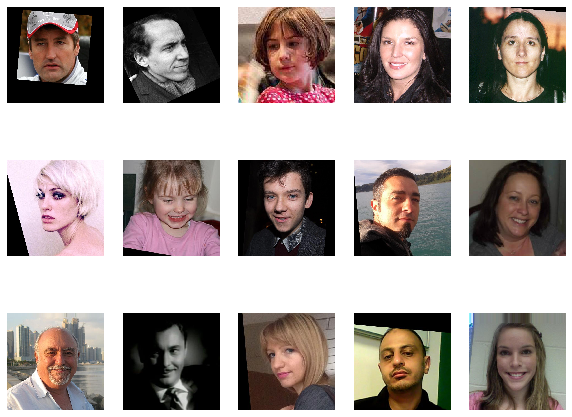

In [6]:
data = os.listdir('/datasets/faces/final_files/')

fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(10, 8))
for ax, path in zip(axs.ravel(), data[:16]):
    img = plt.imread('/datasets/faces/final_files/' + path)
    ax.imshow(img)
    ax.axis('off')

## Modeling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [7]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [8]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv('/datasets/faces/labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, vertical_flip=True, rescale = 1/255)
        
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset= 'training',
        seed=12345) 

    return train_gen_flow

In [9]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv('/datasets/faces/labels.csv')
    
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale = 1/255)
         
    test_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'validation',
        seed=12345) 

    return test_gen_flow

In [10]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(
        input_shape=input_shape, weights='imagenet', include_top=False
    )

    model = Sequential()
    model.add(backbone)

    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='softmax'))

    optimizer = Adam(lr=0.01)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    return model

In [11]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch = steps_per_epoch,
          validation_steps= validation_steps,
          verbose=2)
    
    return model

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [12]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

## Conclusions

- Our goal was to predict age based off of photos of people.
- We added to the data by horizontally flipping the photos using ImageDataGenerator.
- ResNET50 architecture was used for the neural network.
- MSE was used as our loss function because it computes faster that MAE.
- Our model had 1 output because this a regression task. 
- Relu activation function was used to cut off negative values, because age can't be < 0.
- We successfully reached val_mae < 7.
- If we want to further decrease MAE we can add more data by zooming in on the photos or rotating them.

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training